# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [111]:
!pip install jupyter_contrib_nbextensions
!pip install jupyter contrib nbextension install --user
!pip install jupyter nbextension enable python-markdown/main

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement nbextension (from versions: none)
ERROR: No matching distribution found for nbextension
Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: 'python-markdown/main'
Hint: It looks like a path. File 'python-markdown/main' does not exist.


In [1]:
#В рамках предыдущих работ
import pandas as pd
from pymystem3 import Mystem
from nltk.stem import SnowballStemmer 
russian_stemmer = SnowballStemmer('russian')
from collections import Counter
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
import math
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import itertools

#В рамках нового раздела

Считываем в DataFrame данные по добывающей компании «ГлавРосГосНефть».

In [2]:
data_region_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_region_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_region_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_list=[]
for i in range(3):
    print('region', i)
    exec('data_'+str(i)+ "=pd.read_csv('/datasets/geo_data_"+str(i)+".csv')")
    exec(f'display(data_{i}.head())')
    exec(f'display(data_{i}.sample())')
    exec(f'display(data_{i}.tail())')
    exec(f'data_{i}.info()')
    exec(f'data_list.append(data_{i})')
    print('\n', '====='*20, '\n')

region 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
22191,5jdNh,1.057403,0.296957,0.785849,55.766655


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


region 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
32273,SyEXP,3.93227,0.215154,-0.004799,0.0


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


region 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,id,f0,f1,f2,product
16234,J3IEw,1.659445,-1.520376,-2.287513,141.072806


,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB




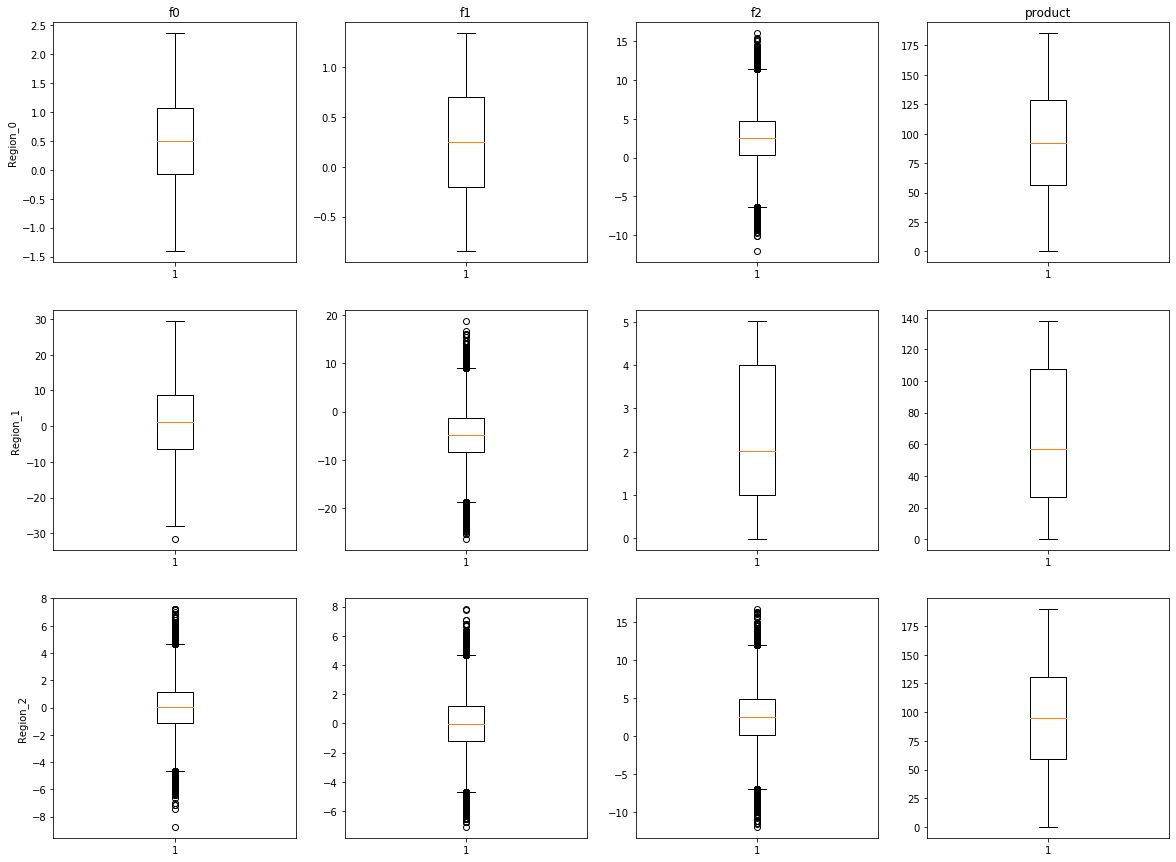

In [4]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["Region_0","Region_1","Region_2"]
num_columns = data_region_0.columns[1:]
num_columns_with_columns = zip(data_region_0.columns[1:],range(4))
all_frames_with_rows = zip([data_region_0,data_region_1,data_region_2],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Как позазывают графики, в столбцах f2 в регионе 0 и 2, f1 в регионе 1 и 2 и в столбце f0 в регионе 2 наблюдается огромное значение аутлайнеров. В этой связи следовало бы посмотреть количество аутлайнеров. 

In [5]:
data_region_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_region_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Region 0


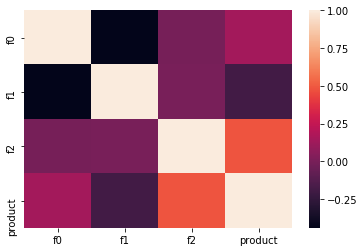

In [8]:
print('Region 0')
corr_matrix = data_region_0.drop(['id'], axis=1).corr()
sns.heatmap(corr_matrix);

Region 1


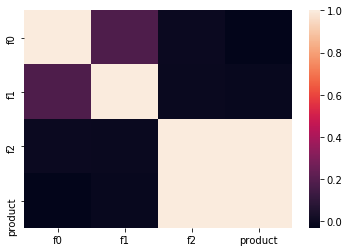

In [9]:
print('Region 1')
corr_matrix = data_region_1.drop(['id'], axis=1).corr()
sns.heatmap(corr_matrix);

Region 2


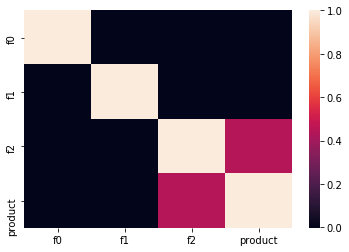

In [10]:
print('Region 2')
corr_matrix = data_region_2.drop(['id'], axis=1).corr()
sns.heatmap(corr_matrix);

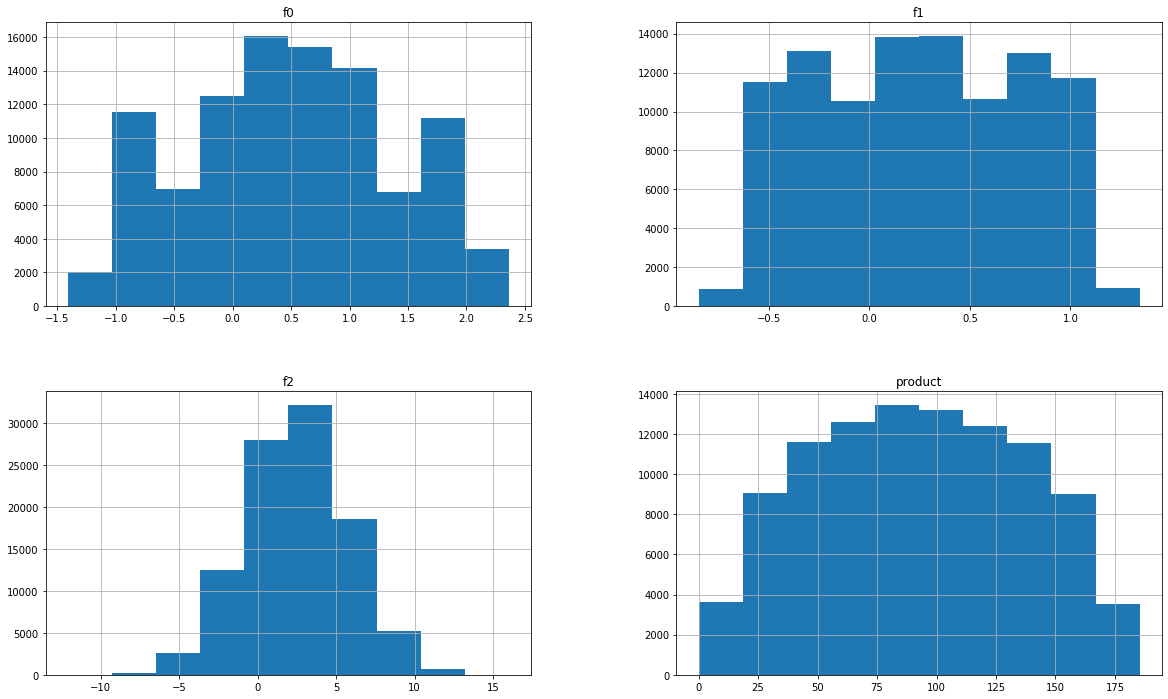

In [11]:
features = list(set(data_region_0.columns) - set(['id']))

data_region_0[features].hist(figsize=(20,12));

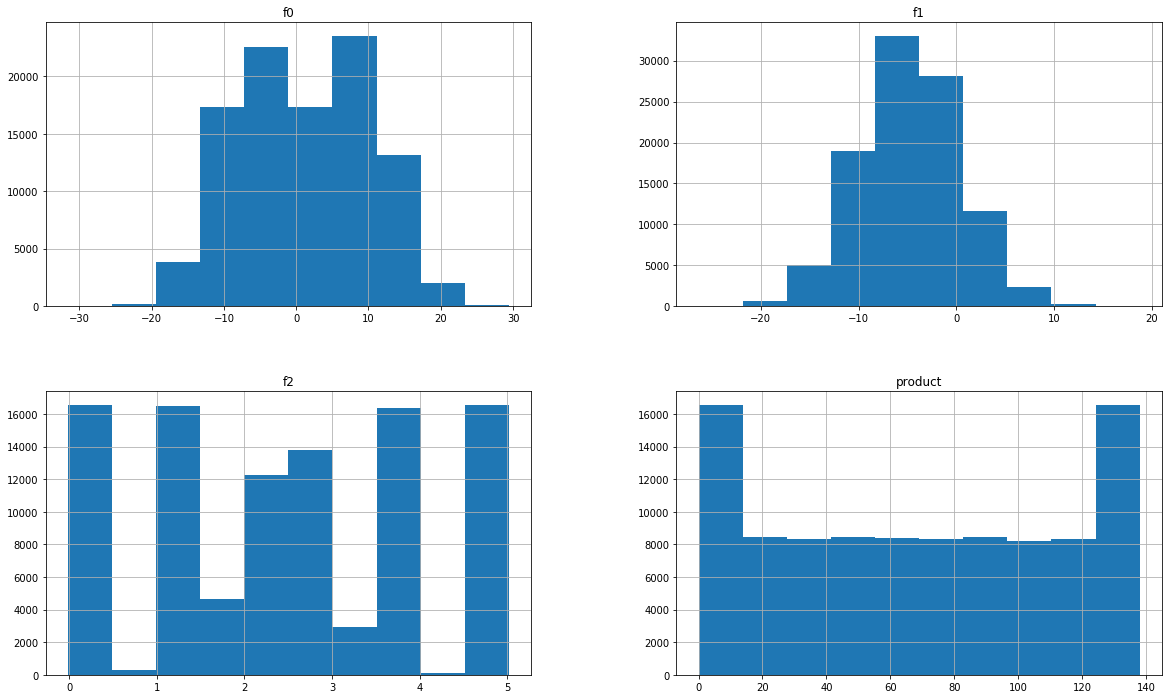

In [12]:
features = list(set(data_region_1.columns) - set(['id']))

data_region_1[features].hist(figsize=(20,12));

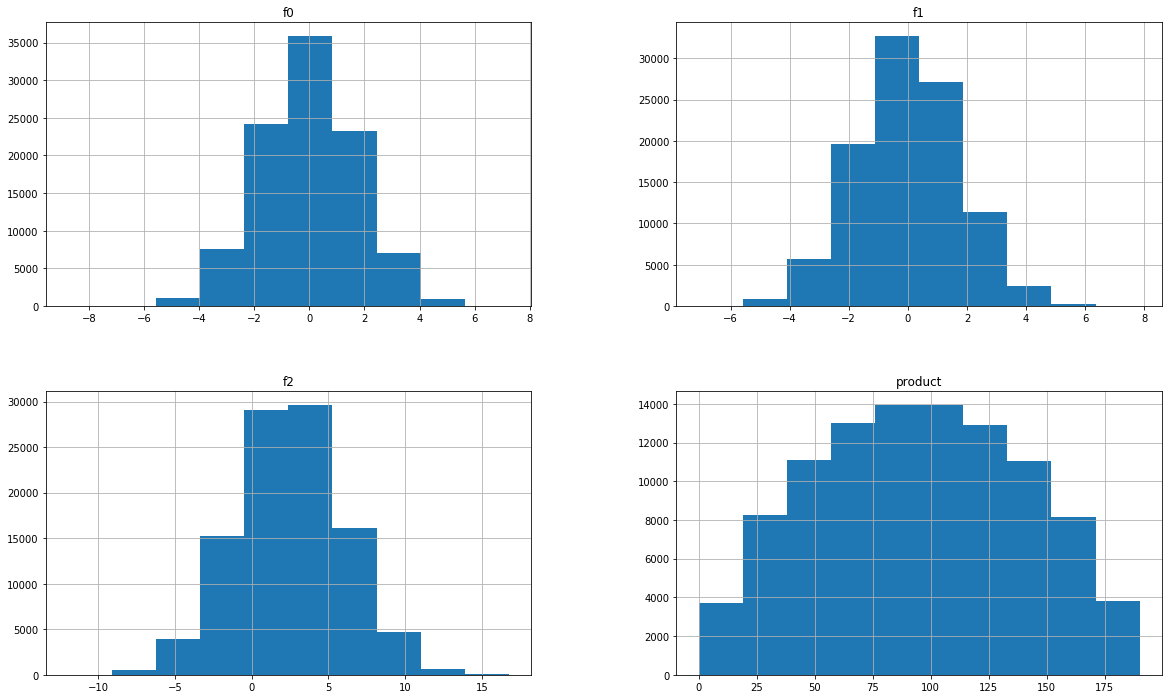

In [13]:
features = list(set(data_region_2.columns) - set(['id']))

data_region_2[features].hist(figsize=(20,12));

На последок исключим столбец ID поскольку для нас никакой ценности данный столбец 

In [14]:
data_region_0 = data_region_0.drop(['id'], axis=1)
data_region_1 = data_region_1.drop(['id'], axis=1)
data_region_2 = data_region_2.drop(['id'], axis=1)

### Вывод

В целом значительных ошибок, пропусков и т.д выявлено не было. Были исключены значения которые в дальнейшем нам бы мешали в нашем исследований. Также, корреляция наблюдается не значительная, в большинства случаев корреляция отсутствует. Также наблюдается не здоровое распределение гистограм у региона №1

## Обучение и проверка модели

### Разбиение данных на выборки

Для максимальной оптимизации мы постраемся напишем необходимую функцию разбиение на выборки

In [15]:
#фнукция разбиение данные на обучаемую и валидационную выборки
def test_split(data, target):
    features = data.drop([target] , axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    return features_train, features_valid, target_train, target_valid

In [16]:
features_train_region_0, features_valid_region_0, target_train_region_0, target_valid_region_0 = test_split(data_region_0, 'product')

In [17]:
print(features_train_region_0.shape)
print(features_valid_region_0.shape)


print(target_train_region_0.shape)
print(target_valid_region_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [18]:
features_train_region_1, features_valid_region_1, target_train_region_1, target_valid_region_1 = test_split(data_region_1, 'product')

print(features_train_region_1.shape)
print(features_valid_region_1.shape)


print(target_train_region_1.shape)
print(target_valid_region_1.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [19]:
features_train_region_2, features_valid_region_2, target_train_region_2, target_valid_region_2 = test_split(data_region_2, 'product')

print(features_train_region_2.shape)
print(features_valid_region_2.shape)


print(target_train_region_2.shape)
print(target_valid_region_2.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


### Строим линейнную регрессию

In [20]:
model = LinearRegression()

In [21]:
def reg_model(features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    
    return rmse

In [22]:
rsme_reg_0 = reg_model(features_train_region_0, target_train_region_0, features_valid_region_0, target_valid_region_0)    
rsme_reg_1 = reg_model(features_train_region_1, target_train_region_1, features_valid_region_1, target_valid_region_1)    
rsme_reg_2 = reg_model(features_train_region_2, target_train_region_2, features_valid_region_2, target_valid_region_2)    

In [23]:
print('--------------------------------')
print('Регион 0')
print('RMSE:', rsme_reg_0)
print('--------------------------------')
print('Регион 1')
print('RMSE:', rsme_reg_1)
print('--------------------------------')
print('Регион 2')
print('RMSE:', rsme_reg_2)
print('--------------------------------')

--------------------------------
Регион 0
RMSE: 37.5794217150813
--------------------------------
Регион 1
RMSE: 0.893099286775616
--------------------------------
Регион 2
RMSE: 40.02970873393434
--------------------------------


Судя по всему лучшие результаты по RSME имеет регион №2

In [24]:
#Напечатайте на экране средний запас предсказанного сырья и RMSE модели

In [25]:
def predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [26]:
data_region_0_pred, rmse_region_0, mean_region_0, data_region_0_pred_sum = predict(data_region_0, 'product')
print('Регион 0')
print('------------------------------------------------------------------')
print(data_region_0_pred.head())
print('------------------------------------------------------------------')
print('RMSE:', rmse_region_0)
print('------------------------------------------------------------------')
print('Средний прогнозируемый запас запасанного сырья:', mean_region_0)
print('------------------------------------------------------------------')
print('Общая сумма прогнозируемых запасов:',data_region_0_pred_sum)

Регион 0
------------------------------------------------------------------
       real_product  predicted_product
71751     10.038645          95.894952
80493    114.551489          77.572583
2655     132.603635          77.892640
53233    169.072125          90.175134
91141    122.325180          70.510088
------------------------------------------------------------------
RMSE: 37.5794217150813
------------------------------------------------------------------
Средний прогнозируемый запас запасанного сырья: 92.59256778438038
------------------------------------------------------------------
Общая сумма прогнозируемых запасов: 2314814.1946095093


In [27]:
data_region_1_pred, rmse_region_1, mean_region_1, data_region_1_pred_sum = predict(data_region_1, 'product')

print('Регион 1')
print('------------------------------------------------------------------')
print(data_region_1_pred.head())
print('------------------------------------------------------------------')
print('RMSE:', rmse_region_1)
print('------------------------------------------------------------------')
print('Средний прогнозируемый запас запасанного сырья:', mean_region_1)
print('------------------------------------------------------------------')
print('Общая сумма прогнозируемых запасов:',data_region_1_pred_sum)

Регион 1
------------------------------------------------------------------
       real_product  predicted_product
71751     80.859783          82.663314
80493     53.906522          54.431786
2655      30.132364          29.748760
53233     53.906522          53.552133
91141      0.000000           1.243856
------------------------------------------------------------------
RMSE: 0.893099286775616
------------------------------------------------------------------
Средний прогнозируемый запас запасанного сырья: 68.728546895446
------------------------------------------------------------------
Общая сумма прогнозируемых запасов: 1718213.67238615


In [28]:
data_region_2_pred, rmse_region_2, mean_region_2, data_region_2_pred_sum = predict(data_region_2, 'product')

print('Регион 2')
print('------------------------------------------------------------------')
print(data_region_2_pred.head())
print('------------------------------------------------------------------')
print('RMSE:', rmse_region_2)
print('------------------------------------------------------------------')
print('Средний прогнозируемый запас запасанного сырья:', mean_region_2)
print('------------------------------------------------------------------')
print('Общая сумма прогнозируемых запасов:',data_region_2_pred_sum)

Регион 2
------------------------------------------------------------------
       real_product  predicted_product
71751     61.212375          93.599633
80493     41.850118          75.105159
2655      57.776581          90.066809
53233    100.053761         105.162375
91141    109.897122         115.303310
------------------------------------------------------------------
RMSE: 40.02970873393434
------------------------------------------------------------------
Средний прогнозируемый запас запасанного сырья: 94.96504596800489
------------------------------------------------------------------
Общая сумма прогнозируемых запасов: 2374126.1492001223


### Выводы

In [29]:
print('Общая сумма прогнозируемых запасов регион 0:', data_region_0_pred_sum.astype(int))
print('Общая сумма реальных запасов регион 0:', target_valid_region_0.sum().astype(int))
print('----------------------------------------------------')
print('Общая сумма прогнозируемых запасов регион 1', data_region_1_pred_sum.astype(int))
print('Общая сумма реальных запасов регион 1:', target_valid_region_1.sum().astype(int))
print('----------------------------------------------------')
print('Общая сумма прогнозируемых запасов регион 2', data_region_2_pred_sum.astype(int))
print('Общая сумма реальных запасов регион 2:', target_valid_region_2.sum().astype(int))
print('----------------------------------------------------')
print('Разнимца между фактом и прогнозом в регионе 0', target_valid_region_0.sum().astype(int) - data_region_0_pred_sum.astype(int))
print('Разнимца между фактом и прогнозом в регионе 1', target_valid_region_1.sum().astype(int) - data_region_1_pred_sum.astype(int))
print('Разнимца между фактом и прогнозом в регионе 2', target_valid_region_2.sum().astype(int) - data_region_2_pred_sum.astype(int))

Общая сумма прогнозируемых запасов регион 0: 2314814
Общая сумма реальных запасов регион 0: 2301964
----------------------------------------------------
Общая сумма прогнозируемых запасов регион 1 1718213
Общая сумма реальных запасов регион 1: 1718078
----------------------------------------------------
Общая сумма прогнозируемых запасов регион 2 2374126
Общая сумма реальных запасов регион 2: 2372105
----------------------------------------------------
Разнимца между фактом и прогнозом в регионе 0 -12850
Разнимца между фактом и прогнозом в регионе 1 -135
Разнимца между фактом и прогнозом в регионе 2 -2021


Как показывают данные, в регионах ниже на 12 850, 132 и 2021. 
В обшем и в целом, модель линейной регресси хорошо продемонстрировала себя на регионе 1. Однако, в регионе 0 и 2 значительно больше объемов нефти, в этой связи нет смысла расматривать регион 1. 

## Подготовка к расчёту прибыли

In [30]:
BUDGET = 1.00E+10
CHOSEN_POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450

In [31]:
average_profit_per_point = (BUDGET / BEST_POINTS) / 1000
print('Средний доход на лучшую точку:', int(average_profit_per_point), 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / PRICE_PER_BARREL
print('Средний объем нефти на точку -',int(average_barrels_per_point), 'тыс. барелей')

average_barrels = BUDGET / PRICE_PER_BARREL
print('Средний объем нефти на регион -',int(average_barrels), 'тыс. барелей')

Средний доход на лучшую точку: 50000 тыс.руб.
Средний объем нефти на точку - 111 тыс. барелей
Средний объем нефти на регион - 22222222 тыс. барелей


Исходя из расчетов, нам нужно выбрать регион, который имеет объем нефти на уровне 22222222 баралей, при среднем значение скважены в 111 тыс баралей и доходностью в 50 млн. рублей. 

In [32]:
def hist_draw(data):
    features = list(set(data.columns))
    data.hist(figsize=(20,12));

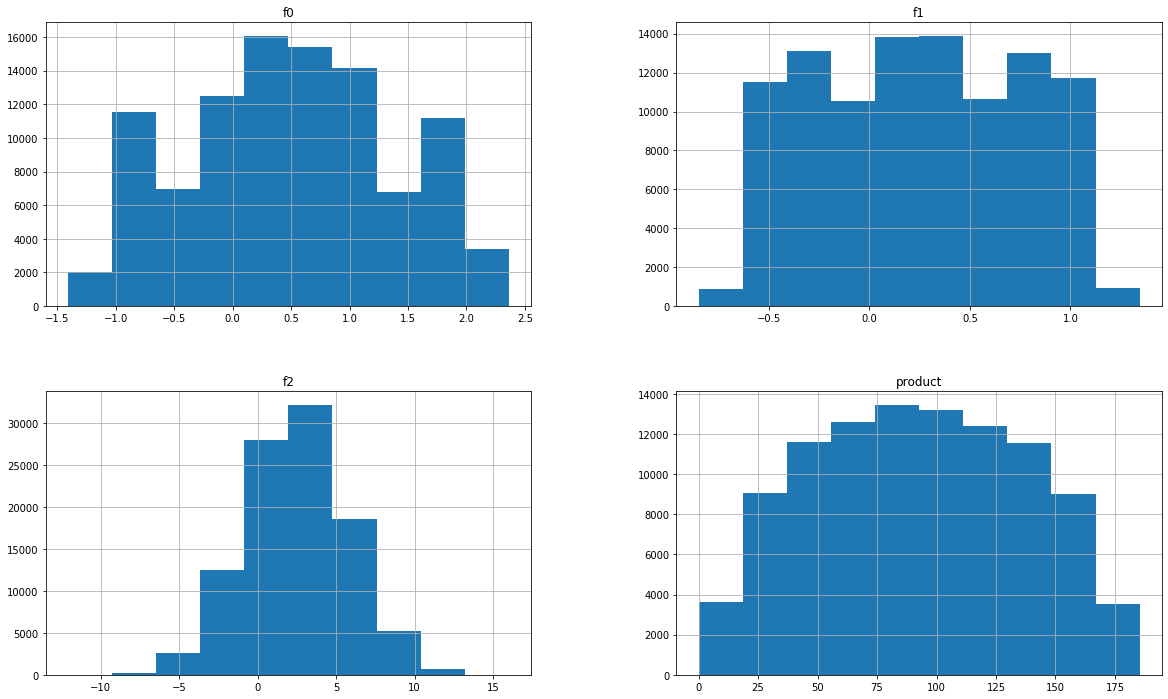

In [33]:
hist_draw(data_region_0)

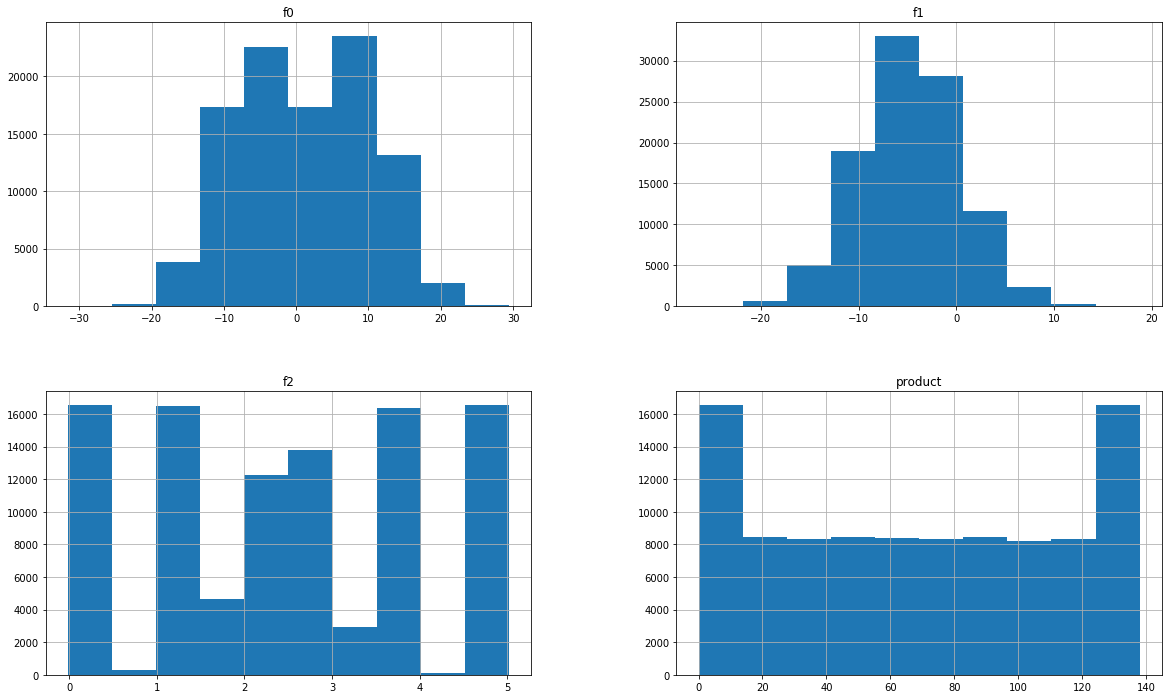

In [34]:
hist_draw(data_region_1)

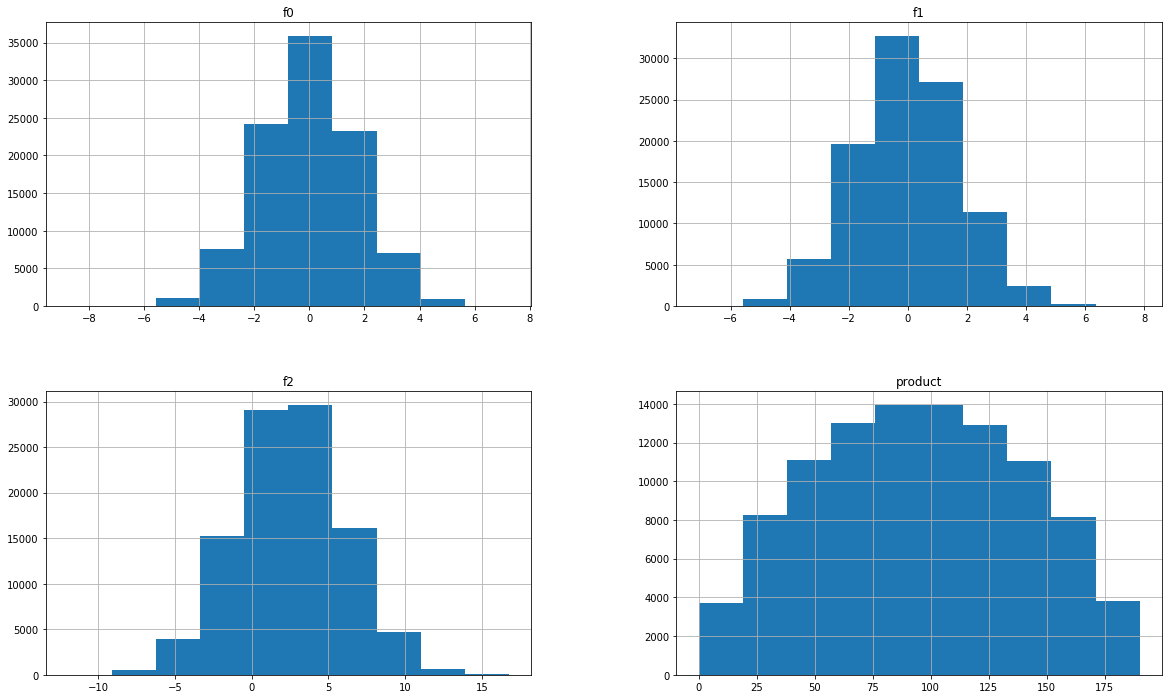

In [35]:
hist_draw(data_region_2)

In [42]:
print('Средний запас фактичекой нефти на скважину в регионе 0', int(data_region_0_pred['real_product'].mean()))
print('Средний запас фактичекой нефти на скважину в регионе 1', int(data_region_1_pred['real_product'].mean()))
print('Средний запас фактичекой нефти на скважину в регионе 2', int(data_region_2_pred['real_product'].mean()))

Средний запас фактичекой нефти на скважину в регионе 0 92
Средний запас фактичекой нефти на скважину в регионе 1 68
Средний запас фактичекой нефти на скважину в регионе 2 94


### Вывод

Исходя из полученных расчетов в разделе 3, наиболее благоприятную обстановку имеют регион 0 и 2

## Расчёт прибыли и рисков 

In [79]:
#функцию для расчета приыли на 500 разведанных точек
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRICE_PER_BARREL * selected.sum() * 1000 - BUDGET

In [80]:
# bootstrap_1000
state = np.random.RandomState(12345)
def bootstrap_1000(target, probs):
    values=[]

    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=CHOSEN_POINTS)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target_sample, probs_sample, BEST_POINTS)
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean() 
    risk = (values < 0).mean() #заменил
    return average, lower, upper, risk

In [95]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(data_region_0_pred['real_product'], 
                                                     data_region_0_pred['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} млн.руб.'.format(average_0 /1000 / 1000))
print('95% доверительный интервал от {:.2f} до {:.2f} млн.руб.'.format(lower_0 /1000 / 1000, upper_0 /1000 / 1000))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону.
Средняя прибыль по региону = 417.74 млн.руб.
95% доверительный интервал от -130.49 до 951.53 млн.руб.
Процент риска 6.60%


In [96]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(data_region_1_pred['real_product'], 
                                                     data_region_1_pred['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f}  млн.руб.'.format(average_1 /1000 / 1000))
print('95% доверительный интервал от {:.2f} до {:.2f} млн.руб.'.format(lower_1 /1000 / 1000, upper_1 /1000 / 1000))
print('Процент риска {:.2%}'.format(risk_1))

Данные по первому региону.
Средняя прибыль по региону = 513.56  млн.руб.
95% доверительный интервал от 106.49 до 925.82 млн.руб.
Процент риска 0.40%


In [97]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(data_region_2_pred['real_product'], 
                                                     data_region_2_pred['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} млн.руб.'.format(average_2 /1000 / 1000))
print('95% доверительный интервал от {:.2f} до {:.2f} млн.руб.'.format(lower_2 /1000 / 1000, upper_2 /1000 / 1000))
print('Процент риска {:.2%}'.format(risk_2))

Данные по первому региону.
Средняя прибыль по региону = 428.41 млн.руб.
95% доверительный интервал от -105.48 до 1002.15 млн.руб.
Процент риска 6.40%


### Вывод

Согласно заданым параметром, был произведен анализ 3 локаций по нефтянным скважинам. Не смотря на то, что объем нефти в регионе 1 меньше чем в других. Однако, результаты демонстрируют высокий уровень окупаемости 200 скважин именно в регионе 1. Тогда как, другие регионы не демоснитруют, высокого уровня окупаемости. Также следует отметить, что регион 0 и 3 имеют высокий риск потерять денежные средства. Также в доверительном интервале регион 0 и 2 наблюдаются значительные потери более чем в 100 млн. рублей. 
Таким обзом, лучше всего инвестировать 10 млрд. рублей лучше всего в регион 1.